## 1. 問題の内容

Q-Learningの強化学習アルゴリズムを用いた自動迷路歩行ロボットの実装．
<img src="default.png" width="20%"></img>
1. 上の図のように、右上にスマートロボットが表示されます．この迷路では、トラップ（赤い爆弾）と終点（青い目標点）の2つのシナリオがあります．ロボットはトラップを回避して、できるだけ早く目的地に到着するようにします．
2. ロボットは、上に行く`u`、右に行く`r`、下に行く`d`、左に行く`l`という動作をすることができます．
3. 様々なアクションを行った後、状況に応じて異なる報酬が与えられます．具体的には以下の通りです．
    - 壁にぶつかる：-10
    - 最後まで歩く：50
    - トラップへの遭遇：-30
    - その他：-0.1
4. 上記の目標を達成するために、`robot.py`のコードを修正して、Q-Learningを実装する．

参考文献：
マップの生成コードhttps://en.wikipedia.org/wiki/Maze_generation_algorithm


## ２. 強化学習アルゴリズムの理解

機械学習アルゴリズムの一種である強化学習は、与えられた課題を達成するために、知能が「訓練」を通じて「経験」を学習する方法としてもモデル化されている．しかし、監督あり学習や監督なし学習とは異なり、強化学習の枠組みでは、知能と環境との相互作用による学習に重きを置いています．一般に監督あり学習や監督なし学習では、知能は与えられた学習目標（例えば損失関数の最小化）により補完された与えられた学習セットと、与えられた学習アルゴリズムによりこの目標を達成することが求められることが多い． 一方、強化学習では、知能は環境との相互作用から得られる報酬を通じて学習する．

強化学習には5つの核となる要素がある：**環境（Environment）**、**エージェント（Agent）**、**状態（State）**、**行動（Action）**と**報酬（Reward）**．ある時刻 $t$において：
    
- エージェントは、環境から自分の状態を知覚している $s_t$
- エージェントは、特定の条件に基づいてアクションを選択する $a_t$
- エージェントが選択した行動に応じて、環境がエージェントに報酬を与える $r_{t+1}$

---

**問題１**：上記の定義を参考に、「ロボットが迷路を走行問題」における強化学習の5つの要素に対応する実際の対象を記述：

- **環境** : 迷路環境は、エージェントが侵入できない壁がある迷路です．エージェントは初期位置を決めて最後までたどり着くことが目標となり、その過程でエージェントは爆弾（トラップ）に触れることができず、壁や爆弾にぶつかるとペナルティ、最後までたどり着くと報酬が与えられます．
- **状態** : 状態は、迷路内の知能の位置の記述で、座標を用いて表現され、例えば、(1,1)となる
- **行動** : アクションとは、ある状態において知的身体が選択する走行方向の記述であり、上u、右r、下d、左lを含む
- **報酬** : 報酬は、歩行中にエージェントが壁にぶつかる：-10、最後まで歩く：50、、トラップまで歩く：-30、それ以外の場合：-0.1です．

$$T(s^{'}, a, s) = P(s^{'}|a,s)$$


---

## ３.Q値の算出 

本プロジェクトでは、Value IterationアルゴリズムであるQ-Learningをベースにした強化学習アルゴリズムを実装しています．Policy Iterationとは異なり、Value Iterationアルゴリズムは、各StateまたはState-ActionのValueまたはUtilityを計算し、アクションの実行時にこの値を最大化しようとするものである．そして、アクションを実行する際に、この値を最大化しようとする．そのため、各状態の値を正確に推定することが、値の反復処理のアルゴリズムの核心となる．
一般的には、行動の長期的な報酬、つまり現在の行動の報酬だけでなく、長期的な報酬を最大化することを考える．

計算式は：

$$
q(s_{t},a) = R_{t+1} + \gamma \times\max_a q(a,s_{t+1})
$$

すなわち、現在の「状態ー行動」 $(s_{t},a)$，に対して、行動 $a$ を行った後に環境から与えられる報酬$R_{t+1}$，行動 $a$ に到達してから任意の行動を行うことで得られる最大Q値 $s_{t+1}$を考慮します，任意の行動を行うことで得られる最大のQ値 $\max_a q(a,s_{t+1})$であり，$\gamma$ は割引係数とする．

## ４.アクションの決め方

強化学習において、「探索-利用」問題は非常に重要な問題である．具体的には、上記の定義に従えば、ロボットに毎回最適な判断をできるだけ選択させることで、長期的な報酬を最大化させることになる．しかし、これには次のような欠点がある：
1. 初期の学習では、Q値が不正確なため、この時点のQ値に従ってすべて選択すると、誤差が生じることになる．
2. 学習期間が過ぎると、ロボットのルートが比較的固定され、ロボットが効率よく環境を探索することができなくなる．

そこで、ε-greedyアルゴリズムの利用を検討する．
ロボットが行動を選択する際には，ランダムな確率と最適なQ値に応じた確率で行動を選択する． 同時に、このランダムな行動を選択する確率は、学習過程とともに徐々に減少するはずである．

**問題 2**：ε-greedyアルゴリズムを実装ます.

In [1]:
import random

actions = ['u','r','d','l']
qline = {'u':1.2, 'r':-2.1, 'd':-24.5, 'l':27}
epsilon = 0.3 # 0.3の確率でランダムに選択されます

def choose_action(epsilon):
    
    action = None
    if random.uniform(0, 1.0) <= epsilon: # 確率
        action = random.choice(actions) # アクションのランダム選択を可能にする
    else: 
        action = max(qline, key=qline.get) # それ以外の場合は、Q値が最大のアクションを選択する
    return action

choose_action(epsilon)

'l'

**問題 3**：マップを生成

C:\Users\Lincle\Downloads\1\probrobo2021-main\probrobo2021\Maze.py:157: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  maze = np.vstack((np.hstack((grid_images[i] for i in row)) for row in self.maze_data))


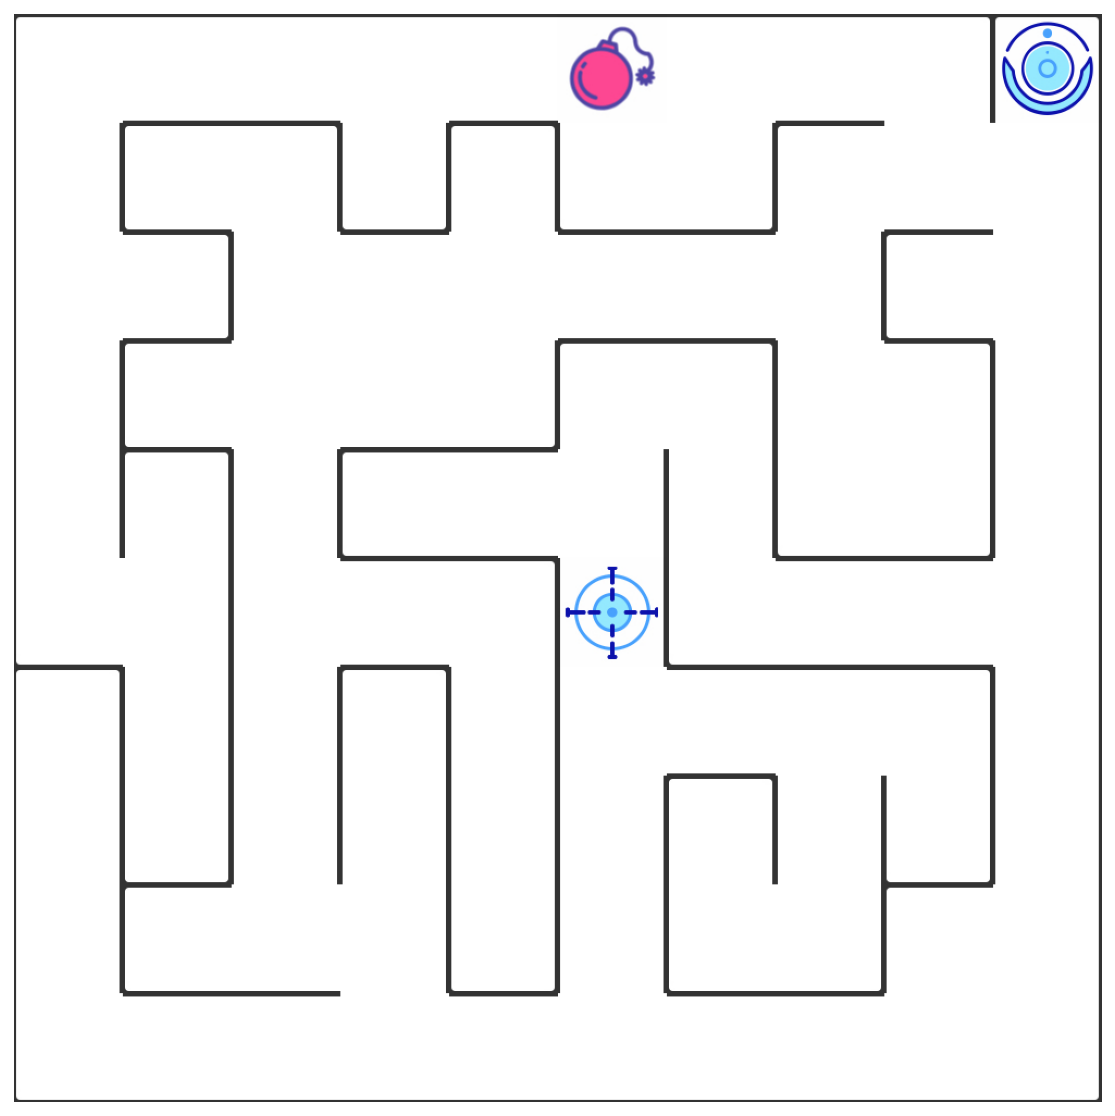

Maze of size (10, 10)

In [2]:
from Maze import Maze
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

g = Maze(maze_size=(10, 10), trap_number=1)
g

**問題 4**：ロボットをランダムに動かし、獲得した報酬を記録し、ロボットの最終位置を表示

(2, 8)


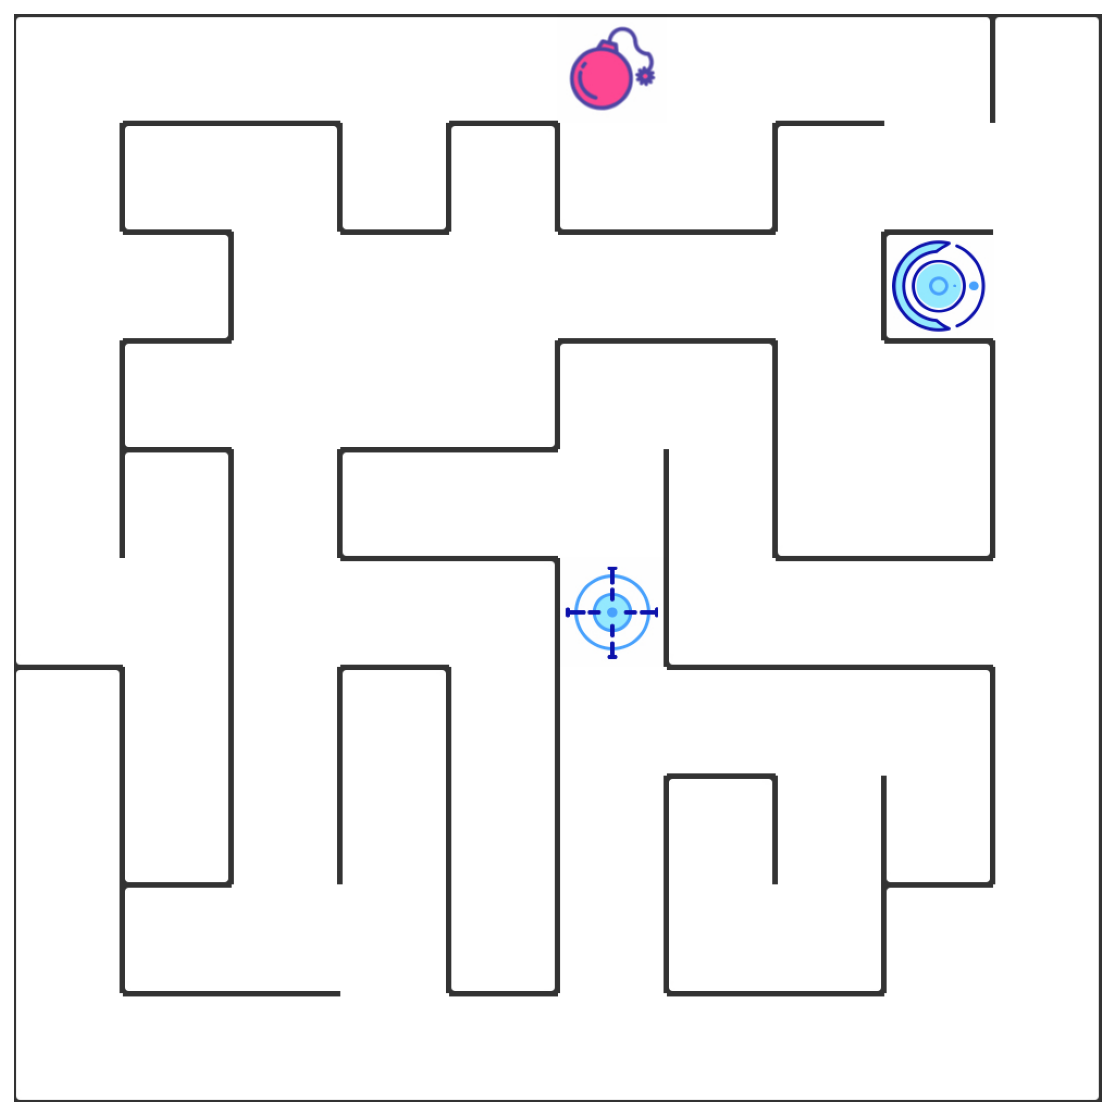

Maze of size (10, 10)

In [3]:
rewards = []

## ループで、ロボットをランダムに10回動かし、報酬を記録する
for i in range(10):
    g.move_robot(random.choice(actions))

## ロボットの最終位置を出力
print(g.sense_robot())

## ロボット位置の観察
g

---

**問題 5**：Robot.py`を実装し次のコードで効果を確認します



('u', -10.0)


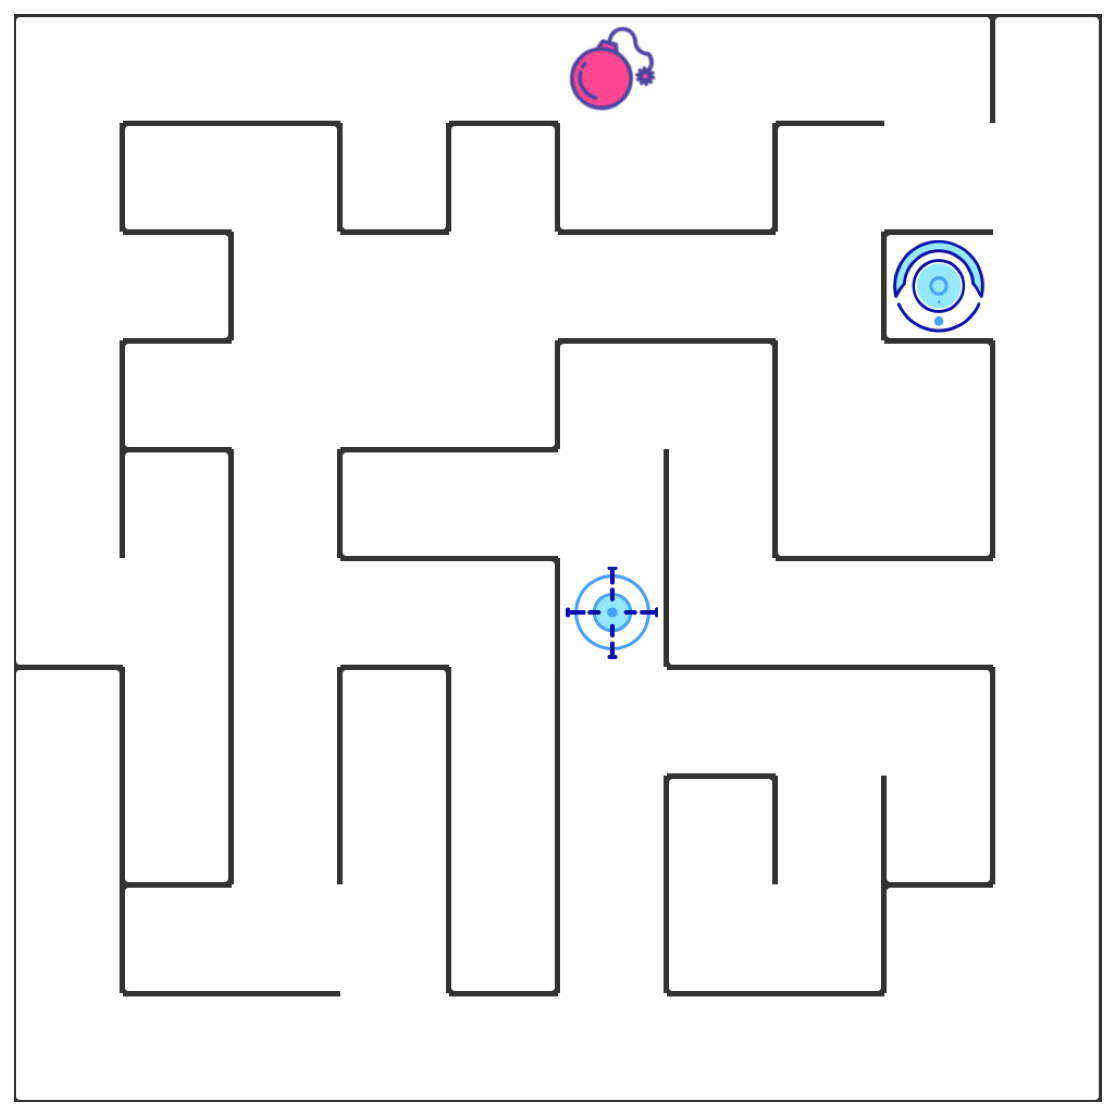

Maze of size (10, 10)

In [4]:
from Robot import Robot
robot = Robot(g) 
robot.set_status(learning=True,testing=False)
print(robot.update())
g

---

## 5.Robotをトレーニング

以下のコードを使用すると、ロボットのトレーニングに成功します. そして、現在のフォルダーに`filename`というビデオができ、トレーニングの全過程が記録されます ．このビデオをご覧になることで、学習過程における問題点を特定し、コードやパラメータを最適化することができます．

---

**問題 6**：以下のコードでパラメータを指定して、ロボットのトレーニングを試す

- トレーニングパラメータ
    - トレーニング回数 `epoch`
- ロボットパラメータ：
    - `epsilon0` (epsilon 初期値)
    - `epsilon`減衰量
- ラビリンスパラメータ:    
    - `alpha` - ラビリンスサイズ
    - `gamma`- 迷路内のトラップ数

In [5]:
epoch = 20

epsilon0 = 0.5
alpha = 0.5
gamma = 0.9

maze_size = (10,10)
trap_number = 1

In [6]:
from Runner import Runner

g = Maze(maze_size=maze_size,trap_number=trap_number)
r = Robot(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)
runner.generate_movie(filename = "final1.mp4") # filenameというビデオを生成

Generate Movies: 100%|██████████| 3000/3000 [01:45<00:00, 28.34it/s]


---

Runner.plot_results()` 関数を使用すると、学習過程におけるロボットのパラメータの一部に関する情報を表示することが可能となる．

- Success Times　学習中にロボットが成功した回数の累積を表す．
- Accumulated Rewards は各トレーニングエポックにおいてロボットが獲得した累積報酬の値を表す
- Running Times per Epoch は各トレーニングエポックにおけるキャリッジのトレーニング回数を表す（エポックの終了時に停止し、次のトレーニングに移行する）
---

**問題 7**：ロボットを分析するための学習結果を出力するには `runner.plot_results()` を使用する．

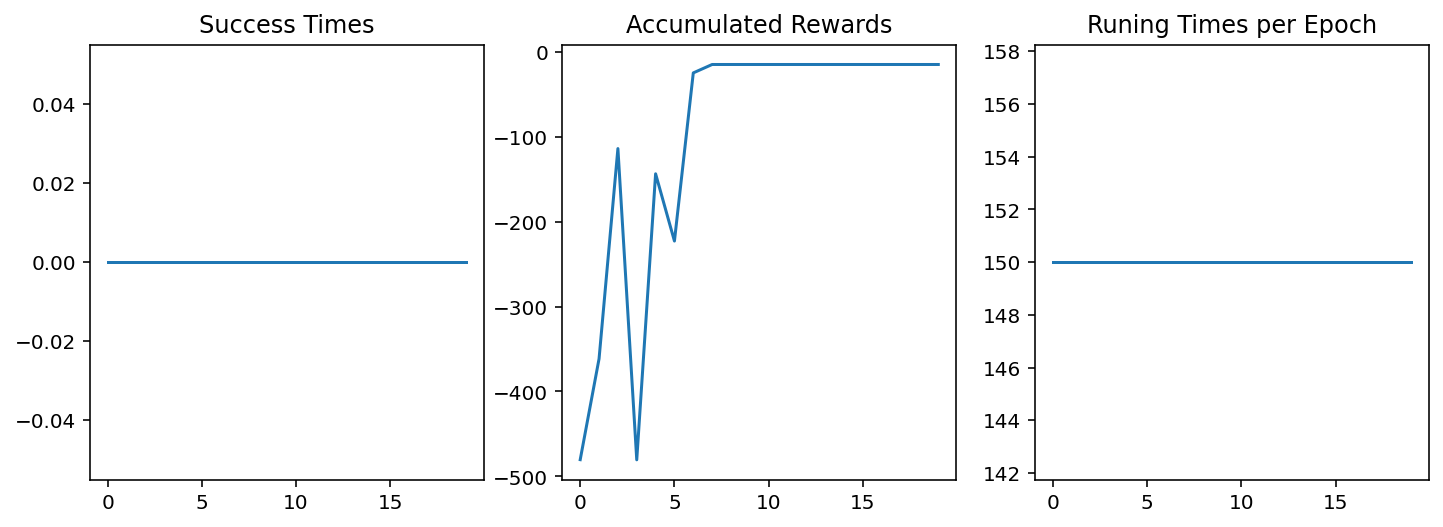

In [7]:
runner.plot_results()